In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib

from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.metrics import *

In [2]:
#read in the data
X_train = pd.read_excel('train_data.xlsx')
y_train = pd.read_excel('train_data.xlsx', sheet_name=1)
X_test = pd.read_excel('test_data.xlsx')
y_test = pd.read_excel('test_data.xlsx', sheet_name=1)

#turn response variable 'dd10 CM content' into a binary class and store in new column 'y'
#y is a binary variable where 1 = Insufficient and 0 = Sufficient
y_train['y'] = y_train['dd10 CM Content']<90
y_train['y'] = y_train['y'].astype('int64')
y_test['y'] = y_test['dd10 CM Content']<90
y_test['y'] = y_test['y'].astype('int64')

#define target column for classification
yc_train = y_train.y 
yc_test = y_test.y

#standardise the data
scaler = StandardScaler()
scaler.fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

#imbalanced data resampling for classification
oversample = SMOTE(random_state=5)
Xs_train, yc_train = oversample.fit_resample(Xs_train, yc_train)
print(Xs_train.shape, yc_train.shape)

(56, 94) (56,)


In [3]:
def show_summary_report(actual, prediction):
    '''Shows accuracy, precision, recall, ROC and 
        visualisations to evaluate a model'''
    
    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, prediction)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

In [4]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

Accuracy : 0.4444 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.2308 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.6154                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


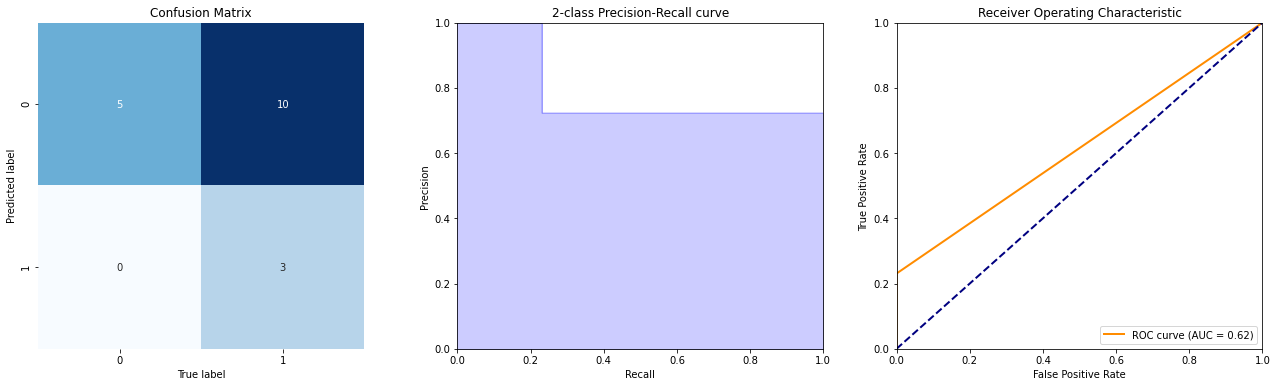

In [5]:
#logistic regression
logr = LogisticRegression(random_state=7)
logr.fit(Xs_train, yc_train)
logr_pred = logr.predict(Xs_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, logr_pred)
# keep the results
results.loc[len(results)] = {
    'Model': 'Log reg (all features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Accuracy : 0.7222 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7222 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


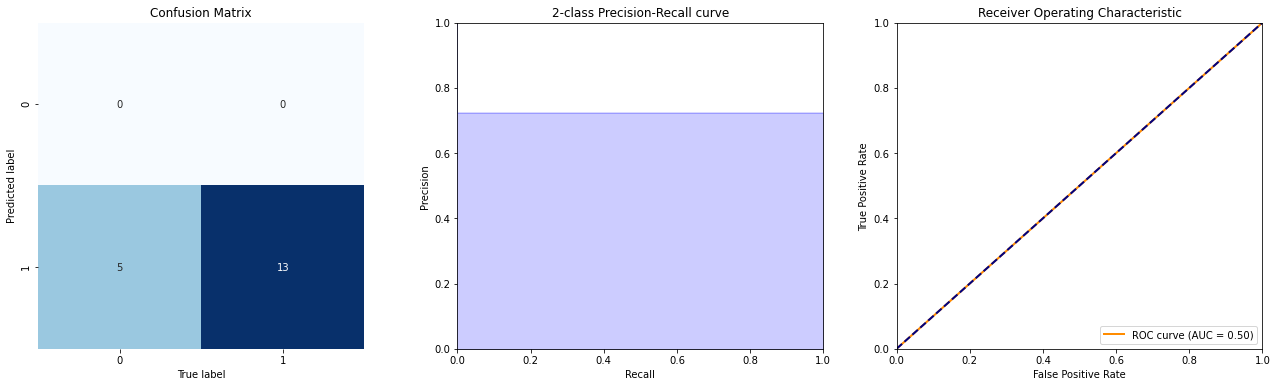

In [6]:
#support vector machine
svc = SVC(random_state=7)
svc.fit(Xs_train, yc_train)
svc_pred = svc.predict(Xs_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, svc_pred)
# keep the results
results.loc[len(results)] = {
    'Model': 'SVM (all features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

0.7222222222222222
Accuracy : 0.7222 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7222 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


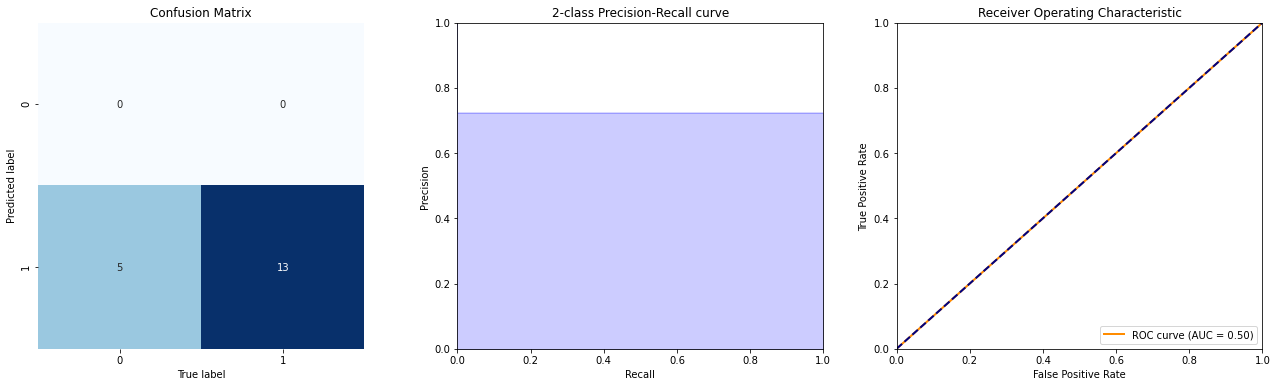

In [7]:
#naive bayes
gauss = GaussianNB()
gauss.fit(Xs_train, yc_train)
print(gauss.score(Xs_test, yc_test))
gauss_pred = gauss.predict(Xs_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, gauss_pred)
# keep the results
results.loc[len(results)] = {
    'Model': 'GaussianNB (all features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Accuracy : 0.2778 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


C:\Users\Avani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


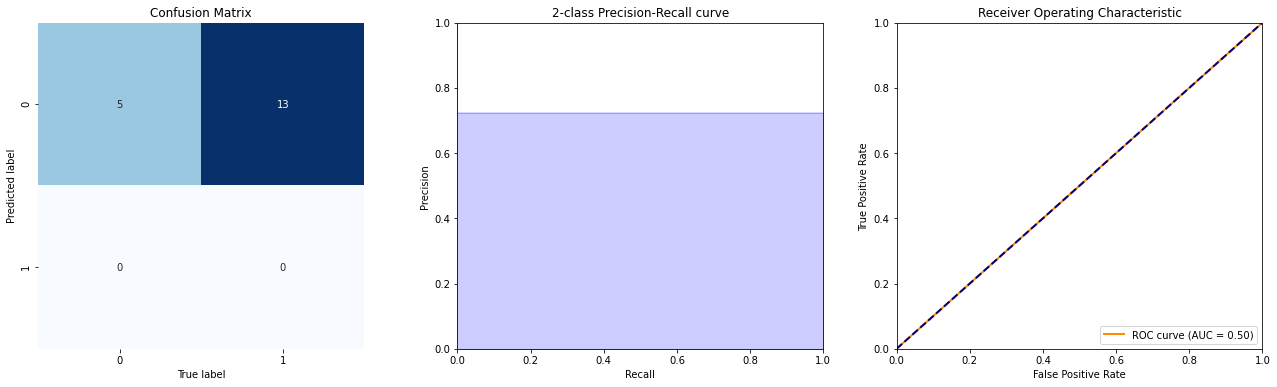

In [8]:
#k nearest neighbors
knn = KNeighborsClassifier()
knn.fit(Xs_train, yc_train)
knn_pred = knn.predict(Xs_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, knn_pred)
# keep the results
results.loc[len(results)] = {
    'Model': 'KNN (all features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Accuracy : 0.7222 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7500 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9231 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5615                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


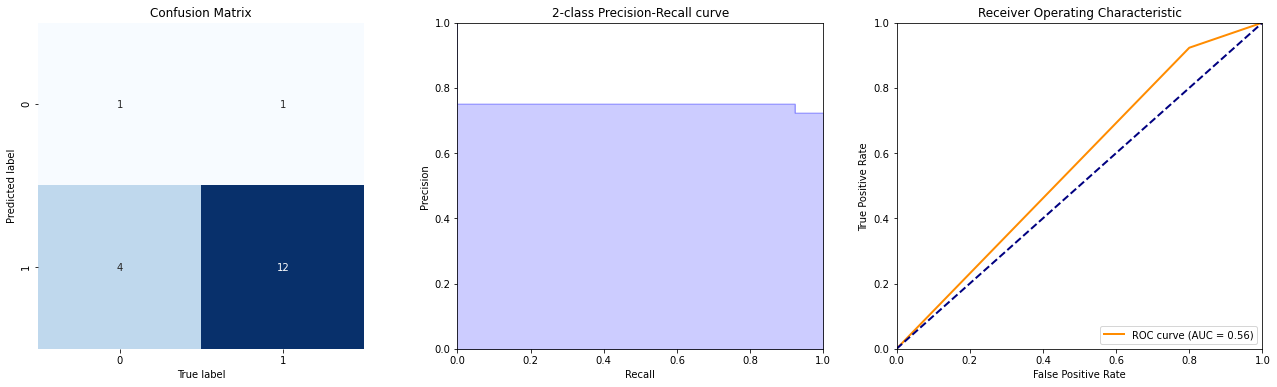

In [9]:
#random forest classifier all features, hyperparameters not tuned yet
rfc = RandomForestClassifier(random_state=7)
rfc.fit(Xs_train, yc_train)
rfc_pred = rfc.predict(Xs_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, rfc_pred)
# keep the results
results.loc[len(results)] = {
    'Model': 'Random Forest (all features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
Best parameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy : 0.8889 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9231 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9231 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8615                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


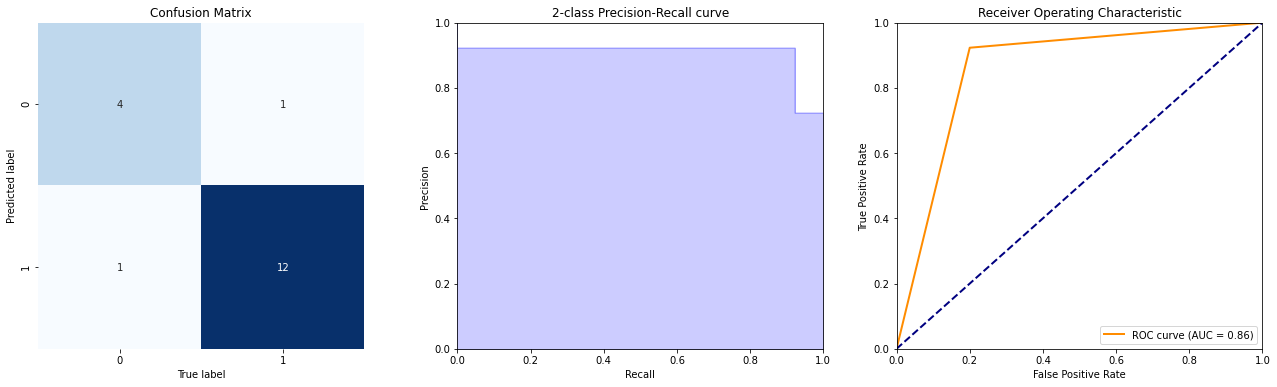


Wall time: 5min 10s


In [10]:
%%time
#hyper parameters on random forest (all features)
rfc_params = {'n_estimators': [5, 50, 100, 200],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'max_depth': [5, 50, 100],
              'min_samples_split': [2, 10, 20],
              'min_samples_leaf': [1,2,5, 10],
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}
rfc_gs = GridSearchCV(RandomForestClassifier(random_state=7), rfc_params, n_jobs= -1, cv=5, verbose=1)
rfc_gs.fit(Xs_train, yc_train)
best_rfc = rfc_gs.best_estimator_
print('Best parameters: ',rfc_gs.best_params_)

#evaluate model
best_rfc_pred = best_rfc.predict(Xs_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, best_rfc_pred)

#keep the results
results.loc[len(results)] = {
    'Model': 'Random Forest (all features, tuned params)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

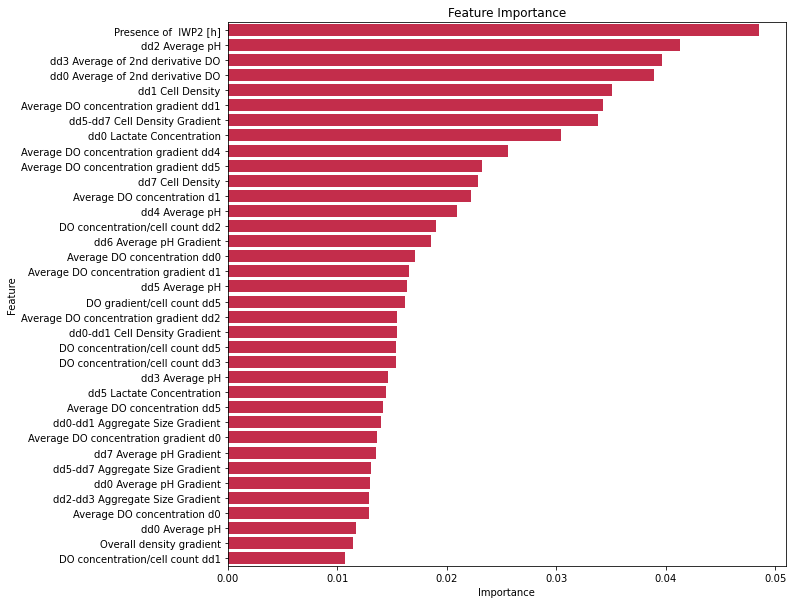

In [11]:
#creating a dataframe of the most important features
imp_best_rfc = pd.DataFrame(list(zip(X_train.columns, best_rfc.feature_importances_)))
imp_best_rfc.columns = ['Feature', 'Importance']
imp36 = imp_best_rfc.sort_values(by='Importance', ascending=False).head(36)

#looking at the most important features
plt.figure(figsize=(10,10))
sns.barplot(x='Importance', y='Feature', data=imp36, orient="h", color='crimson')
plt.title('Feature Importance');

In [12]:
#feature selection using random forest model (made from all features, tuned hyperparameters)
sel = SelectFromModel(best_rfc, prefit = True)
Xs36_train = sel.transform(Xs_train)
Xs36_test = sel.transform(Xs_test)
Xs36_train.shape[1] #This shows that 36 features were selected

36

In [13]:
#to see which features got selected
print(X_train.columns[sel.get_support()])

Index(['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density',
       'dd5-dd7 Cell Density Gradient', 'dd7 Cell Density',
       'dd0-dd1 Aggregate Size Gradient', 'dd2-dd3 Aggregate Size Gradient',
       'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2 [h]',
       'Average DO concentration d0', 'Average DO concentration d1',
       'Average DO concentration dd0', 'Average DO concentration dd5',
       'Average DO concentration gradient d0',
       'Average DO concentration gradient d1',
       'Average DO concentration gradient dd1',
       'Average DO concentration gradient dd2',
       'Average DO concentration gradient dd4',
       'Average DO concentration gradient dd5',
       'DO concentration/cell count dd1', 'DO concentration/cell count dd2',
       'DO concentration/cell count dd3', 'DO concentration/cell count dd5',
       'DO gradient/cell count dd5', 'dd0 Average of 2nd derivative DO',
       'dd3 Average of 2nd derivative DO', 'Overall density gradient',
       'dd0 

Accuracy : 0.7222 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7500 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9231 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5615                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


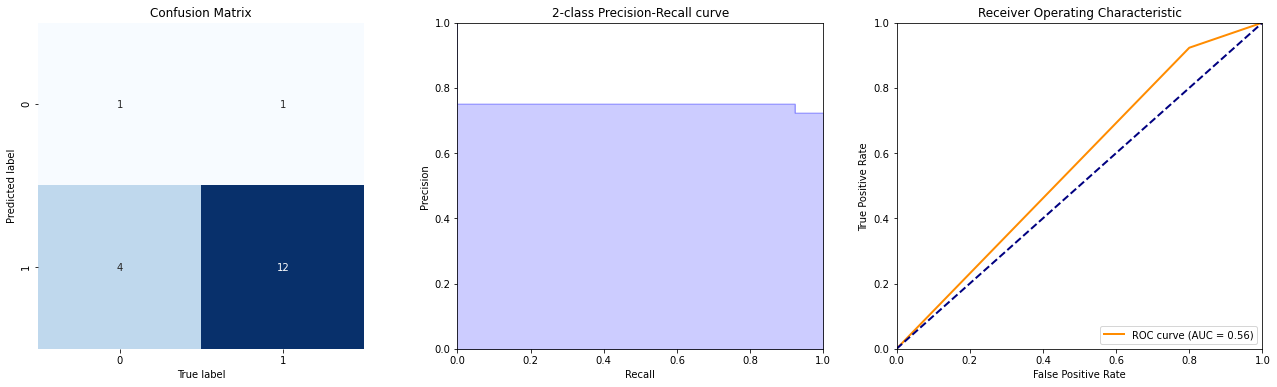

In [14]:
#random forest with 36 features
rfc36 = RandomForestClassifier(random_state=7)
rfc36.fit(Xs36_train, yc_train)
rfc36_pred = rfc36.predict(Xs36_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, rfc36_pred)
# keep the results
results.loc[len(results)] = {
    'Model': 'Random Forest (36 features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 100}
Accuracy : 0.7222 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7500 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9231 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5615                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


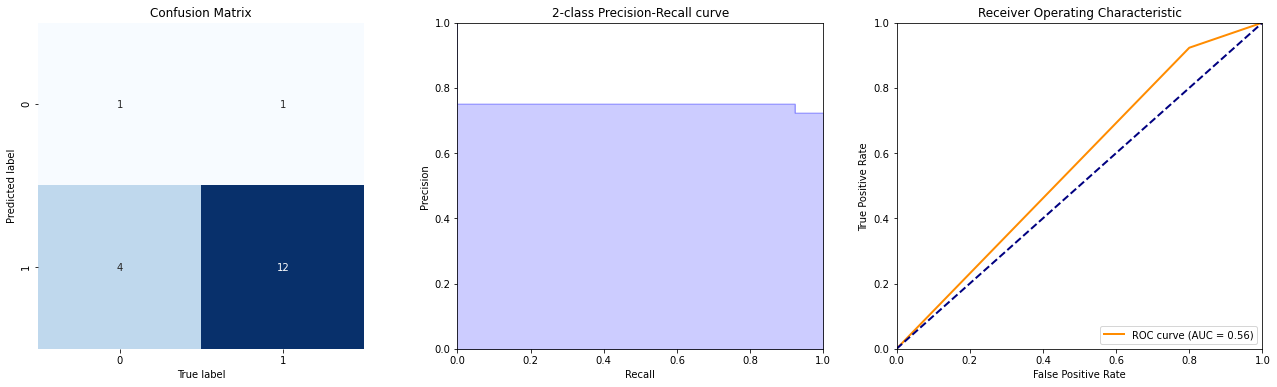


Wall time: 1min 11s


In [15]:
%%time
#hyper parameters on random forest with 36 features
rfc36_params = {'n_estimators': [100, 150, 200],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [2, 5, 10],
              'min_samples_split': [2, 10, 20],
              'min_samples_leaf': [1,2,5, 10],
              'bootstrap': [True],
              'criterion': ['gini']}
rfc36_gs = GridSearchCV(RandomForestClassifier(random_state=7), rfc36_params, n_jobs= -1, cv=5, verbose=1)
rfc36_gs.fit(Xs36_train, yc_train)
best_rfc36 = rfc36_gs.best_estimator_
print('Best parameters: ',rfc36_gs.best_params_)

#evaluate model
best_rfc36_pred = best_rfc36.predict(Xs36_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, best_rfc36_pred)

#keep the results
results.loc[len(results)] = {
    'Model': 'Random Forest (36 features, tuned params)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Fitting 5 folds for each of 162 candidates, totalling 810 fits


C:\Users\Avani\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.83939394 0.85606061 0.85606061 0.85757576 0.83939394 0.83939394
 0.83939394 0.83939394 0.83939394 0.85757576 0.85757576 0.85757576
        nan        nan        nan        nan        nan        nan
 0.87424242 0.87424242 0.87424242 0.82121212 0.82121212 0.83939394
 0.87424242 0.85757576 0.87424242 0.82121212 0.82121212 0.82121212
        nan        nan        nan        nan        nan        nan
 0.80606061 0.8030303  0.78484848 0.80454545 0.80454545 0.80454545
 0.80606061 0.8030303  0.78484848 0.80454545 0.80454545 0.80454545
        nan        nan        nan        nan        nan        nan
 0.83939394 0.85606061 0.83939394 0.85757576 0.83939394 0.83939394
 0.83939394 0.85757576 0.85757576 0.83939394 0.83939394 0.85757576
        nan        nan        nan        nan        n

Best parameters:  {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 5, 'base_estimator__max_features': 'log2', 'base_estimator__min_samples_leaf': 4, 'base_estimator__min_samples_split': 2, 'bootstrap': True, 'n_estimators': 100}
Accuracy : 0.6667 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7333 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8462 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5231                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


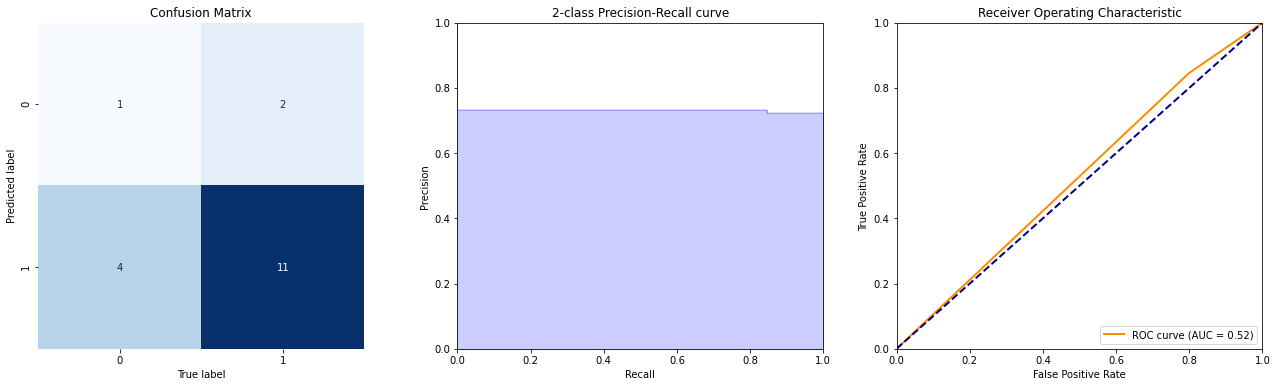


Wall time: 40.5 s


In [16]:
%%time
#bagging decision trees with 36 features
bag_params = {
    'base_estimator__criterion' : ["gini"],
    'base_estimator__max_depth' : [3, 5, 10],
    'base_estimator__min_samples_split': [1, 2, 10],
    'base_estimator__min_samples_leaf': [2,4,10],
    'base_estimator__max_features':["log2"],
    'bootstrap': [True, False],
    'n_estimators': [100, 200, 300]
}

bag_gs = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=7), random_state=7),
                   bag_params, n_jobs= -1, cv = 5, verbose=1)
bag_gs.fit(Xs36_train, yc_train)
best_bag36 = bag_gs.best_estimator_
print('Best parameters: ', bag_gs.best_params_)

#evaluate model
best_bag36_pred = best_bag36.predict(Xs36_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, best_bag36_pred)

# keep the results
results.loc[len(results)] = {
    'Model': 'Bagging (DT) (36 features, tuned params)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Accuracy : 0.7222 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6923 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7462                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


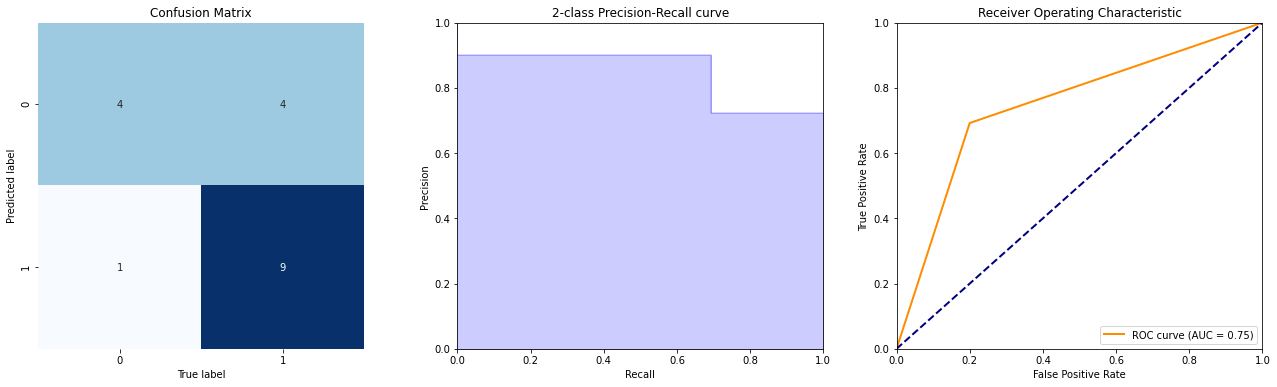


Wall time: 667 ms


In [17]:
%%time
#AdaBoost classifier with 36 features
adab = AdaBoostClassifier(n_estimators=300, random_state=7)
adab.fit(Xs36_train, yc_train)
adab_pred = adab.predict(Xs36_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, adab_pred)

# keep the results
results.loc[len(results)] = {
    'Model': 'AdaBoost (36 features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Accuracy : 0.3889 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.1538 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5769                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


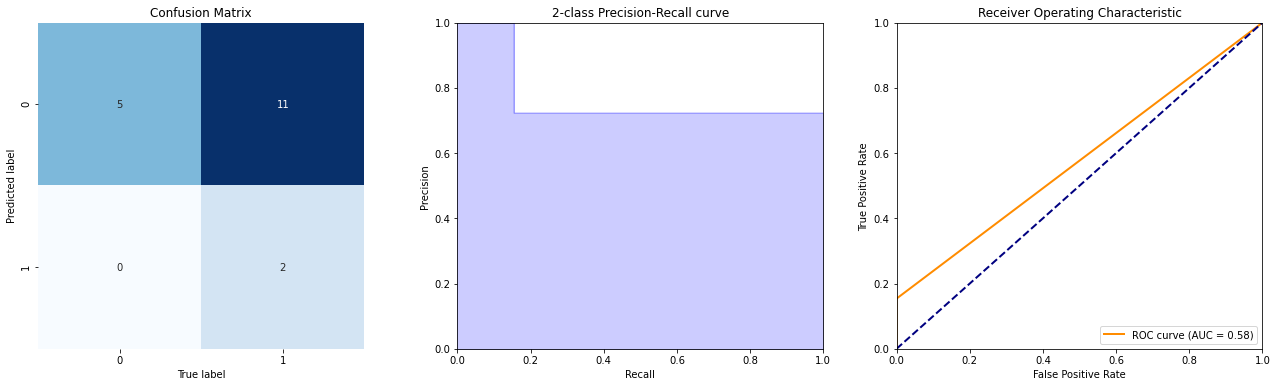


Wall time: 382 ms


In [18]:
%%time
#Gradient boosting classifier
gbc = GradientBoostingClassifier(random_state=7)
gbc.fit(Xs36_train, yc_train)
gbc_pred = gbc.predict(Xs36_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, gbc_pred)

# keep the results
results.loc[len(results)] = {
    'Model': 'Gradient Boost (36 features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

Accuracy : 0.6667 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7333 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8462 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.5231                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


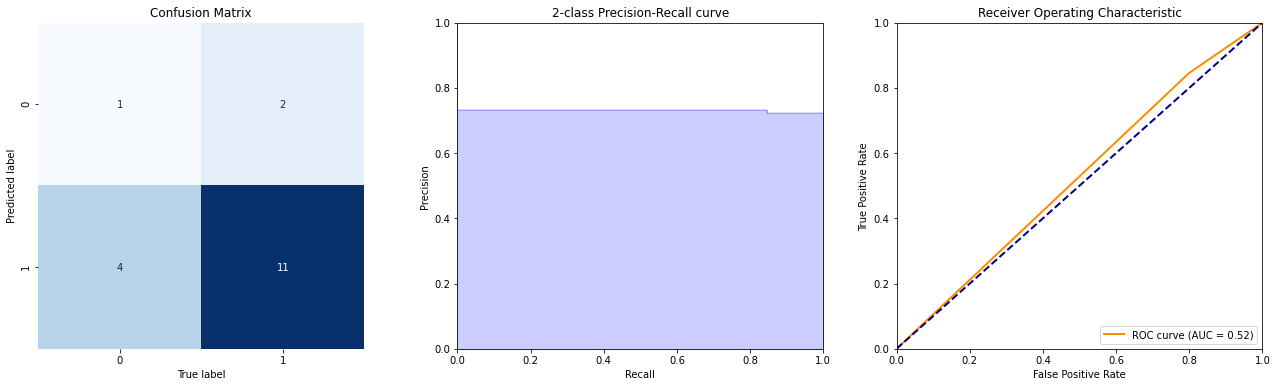


Wall time: 989 ms


In [19]:
%%time
#stacking classifier

#submodels
best_rfc36 #random forest with 36 features
best_bag36 #bagging decision trees with 36 features
adab #AdaBoost with 36 features

#create the ensemble model
sc = StackingClassifier(classifiers = [best_rfc36, best_bag36, adab], 
                        meta_classifier = LogisticRegression(random_state =7))
sc.fit(Xs36_train, yc_train)

#evaluate model
sc_pred = sc.predict(Xs36_test)
accuracy_, precision_, recall_, roc_auc_ = show_summary_report(yc_test, sc_pred)

# keep the results
results.loc[len(results)] = {
    'Model': 'Stacking (36 features)', 
    'Accuracy': accuracy_, 
    'Precision': precision_,
    'Recall': recall_,
    'ROC_AUC': roc_auc_}
print()

In [20]:
#all results
results

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Log reg (all features),0.444444,1.000000,0.230769,0.615385
1,SVM (all features),0.722222,0.722222,1.000000,0.500000
2,GaussianNB (all features),0.722222,0.722222,1.000000,0.500000
3,KNN (all features),0.277778,0.000000,0.000000,0.500000
4,Random Forest (all features),0.722222,0.750000,0.923077,0.561538
5,"Random Forest (all features, tuned params)",0.888889,0.923077,0.923077,0.861538
6,Random Forest (36 features),0.722222,0.750000,0.923077,0.561538
7,"Random Forest (36 features, tuned params)",0.722222,0.750000,0.923077,0.561538
8,"Bagging (DT) (36 features, tuned params)",0.666667,0.733333,0.846154,0.523077
9,AdaBoost (36 features),0.722222,0.900000,0.692308,0.746154


In [24]:
#results shown in presentation
results.drop(index=[0, 1, 2, 3, 4, 6, 10, 11])

,Model,Accuracy,Precision,Recall,ROC_AUC
5,"Random Forest (all features, tuned params)",0.888889,0.923077,0.923077,0.861538
7,"Random Forest (36 features, tuned params)",0.722222,0.750000,0.923077,0.561538
8,"Bagging (DT) (36 features, tuned params)",0.666667,0.733333,0.846154,0.523077
9,AdaBoost (36 features),0.722222,0.900000,0.692308,0.746154


When using all features, the random forest model gives the best accuracy, precision, and recall. 
When only 36 features are used, I would recommend AdaBoostClassifier due to its high precision. It will ensure that experiments that are performing well are not wrongly classified as 'Insufficient'.

In [26]:
#saving the best performing random forest model (made using all features)
joblib.dump(best_rfc, "./best_randomforest.joblib")

['./best_randomforest.joblib']



### This saved model will be used to create a pipeline (see '3_model_pipeline.ipynb')